In [14]:
import pydicom
import os
import numpy
from matplotlib import pyplot, cm
import dicom_numpy
%matplotlib inline  

In [15]:
PathDicom = "/Users/BlauBear/Documents/HS699/SE000001"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [16]:
# Get ref file
RefDs = pydicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [17]:
x = numpy.arange(0.0, (ConstPixelDims[0]+1)*ConstPixelSpacing[0], ConstPixelSpacing[0])
y = numpy.arange(0.0, (ConstPixelDims[1]+1)*ConstPixelSpacing[1], ConstPixelSpacing[1])
z = numpy.arange(0.0, (ConstPixelDims[2]+1)*ConstPixelSpacing[2], ConstPixelSpacing[2])

In [18]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  

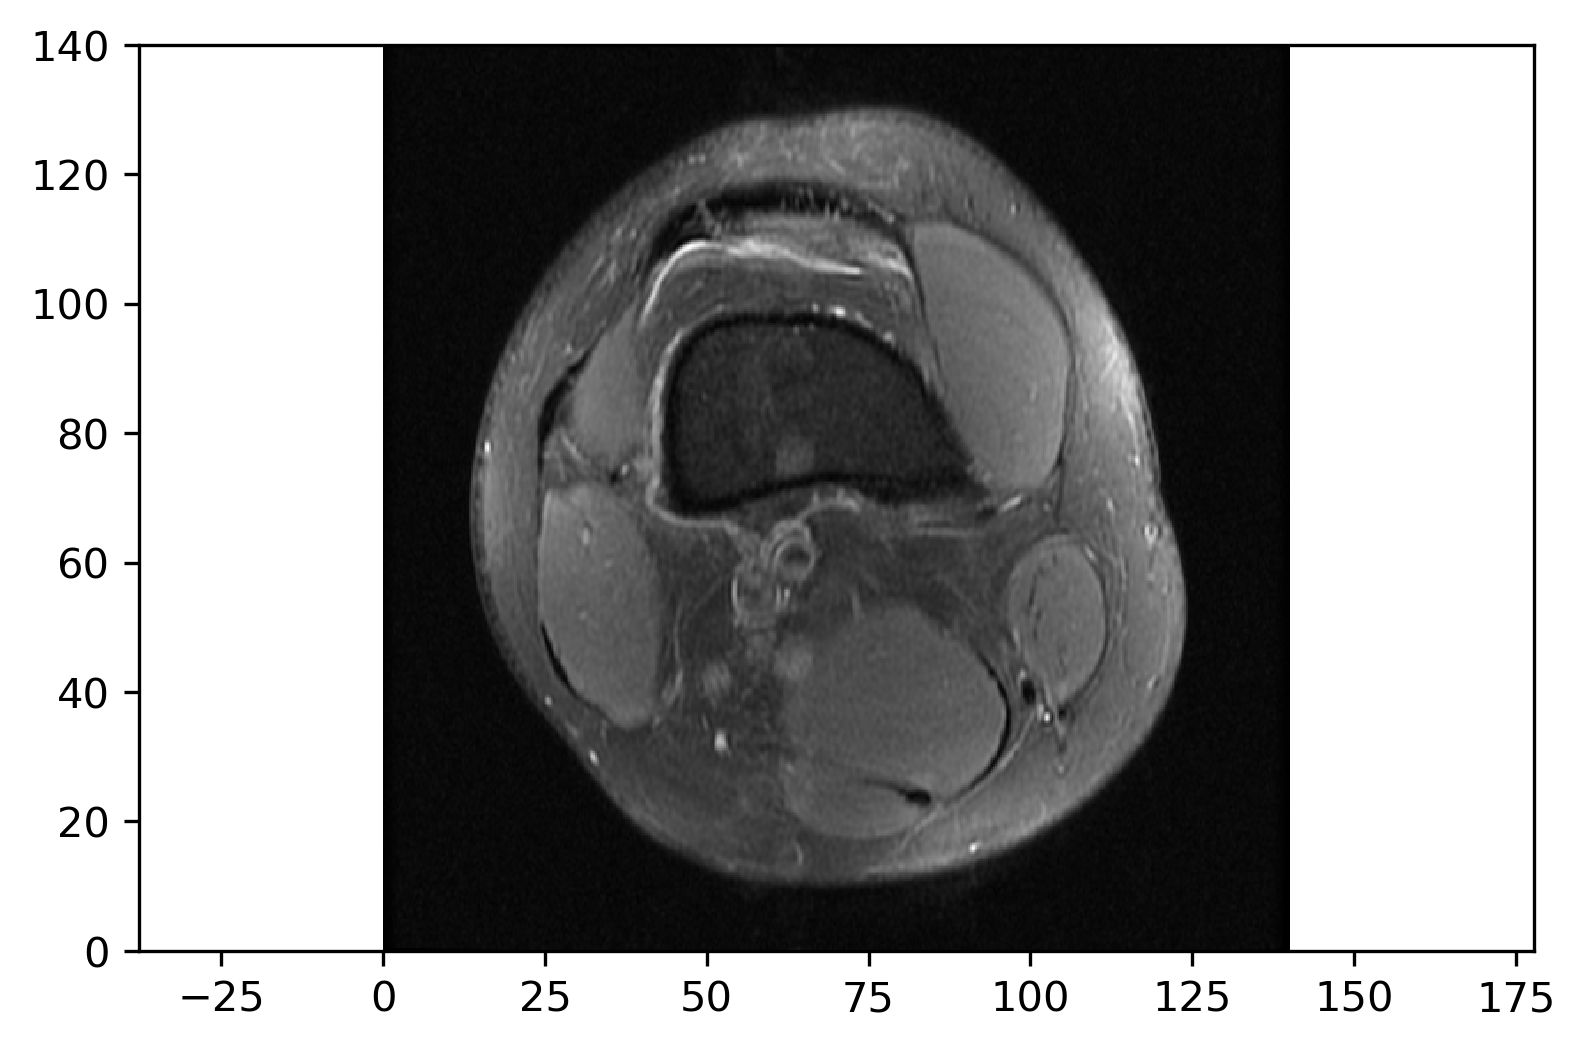

In [19]:
pyplot.figure(dpi=300)
pyplot.axes().set_aspect('equal', 'datalim')
pyplot.set_cmap(pyplot.gray())
pyplot.pcolormesh(x, y, numpy.flipud(ArrayDicom[:, :, 2]))